Set True to save the figures.

In [183]:
save = True

In [184]:
import numpy as np # scientific computing
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # reading images
from skimage.color import rgb2gray # converting rgb images to grayscale

Read images and convert them to grayscale.

In [185]:
img1 = rgb2gray(mpimg.imread('edge1.png'))

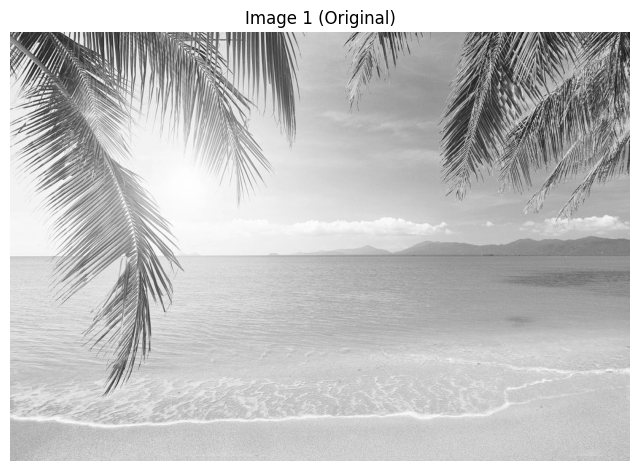

In [186]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Image 1 (Original)')
plt.imshow(img1, cmap='gray')
if save:
    plt.savefig('original1.png')
plt.show()

2D-convolution (actually cross-correlation)

In [187]:
def cross_correlate2D(img, mask):
    n_r, n_c = img.shape
    # Compute row and column offsets
    mask_r, mask_c = mask.shape
    r_offset = mask_r // 2 - (mask_r % 2 == 0)
    c_offset = mask_c // 2 - (mask_c % 2 == 0)
    # Apply zero-padding 
    padded_img = np.pad(img, ((r_offset, r_offset + (mask_r % 2 == 0)),
                              (c_offset, c_offset + (mask_c % 2 == 0))))
    # Perform 2D cross-correlation
    output = np.zeros((n_r, n_c))
    for row in range(r_offset, r_offset + n_r):
        for col in range(c_offset, c_offset + n_c):
            output[row - r_offset, col - c_offset] = np.sum(
                mask *
                padded_img[row - r_offset: row + r_offset + (mask_r % 2 == 0) + 1, 
                           col - c_offset: col + c_offset + (mask_c % 2 == 0) + 1]
            )
    return output

Sobel Operator:

In [188]:
def sobel(img):
    mask_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    mask_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    edge_x = cross_correlate2D(img, mask_x) / 6
    edge_y = cross_correlate2D(img, mask_y) / 6
    gradient_magnitudes = np.sqrt(edge_x ** 2 + edge_y ** 2)
    gradient_magnitudes *= 255 / np.max(gradient_magnitudes)
    gradient_directions = np.arctan2(edge_y, edge_x)
    return edge_x, edge_y, gradient_magnitudes, gradient_directions

Plotting code is refactored as a seperate function to avoid duplicate code. Feel free to change it.

In [189]:
def plot_results1(result1, result2, result3, result4, figsize_, method, img_number, save=False):
    fig, axs = plt.subplots(2, 2, figsize=figsize_)
    axs[0, 0].set_title('Vertical Edges after applying \n' + method + ' Operator to Image ' + img_number)
    axs[0, 0].axis('off')
    axs[0, 0].imshow(result1, cmap='gray')
    axs[0, 1].set_title('Horizontal Edges after applying \n' + method + ' Operator to Image ' + img_number)
    axs[0, 1].axis('off')
    axs[0, 1].imshow(result2, cmap='gray')
    axs[1, 0].set_title('Combined Edges of Image ' + img_number + '\n (Gradient Magnitudes (' + method + '))')
    axs[1, 0].axis('off')
    axs[1, 0].imshow(result3, cmap='gray')
    axs[1, 1].set_title('Gradient Directions (' + method + ') in Image ' + img_number)
    axs[1, 1].axis('off')
    axs[1, 1].imshow(result4)
    if save:
        plt.savefig(method + '_results' + img_number + '.png')
    plt.show()

In [190]:
sobel_x1, sobel_y1, sobel_magnitudes1, sobel_directions1 = sobel(img1)

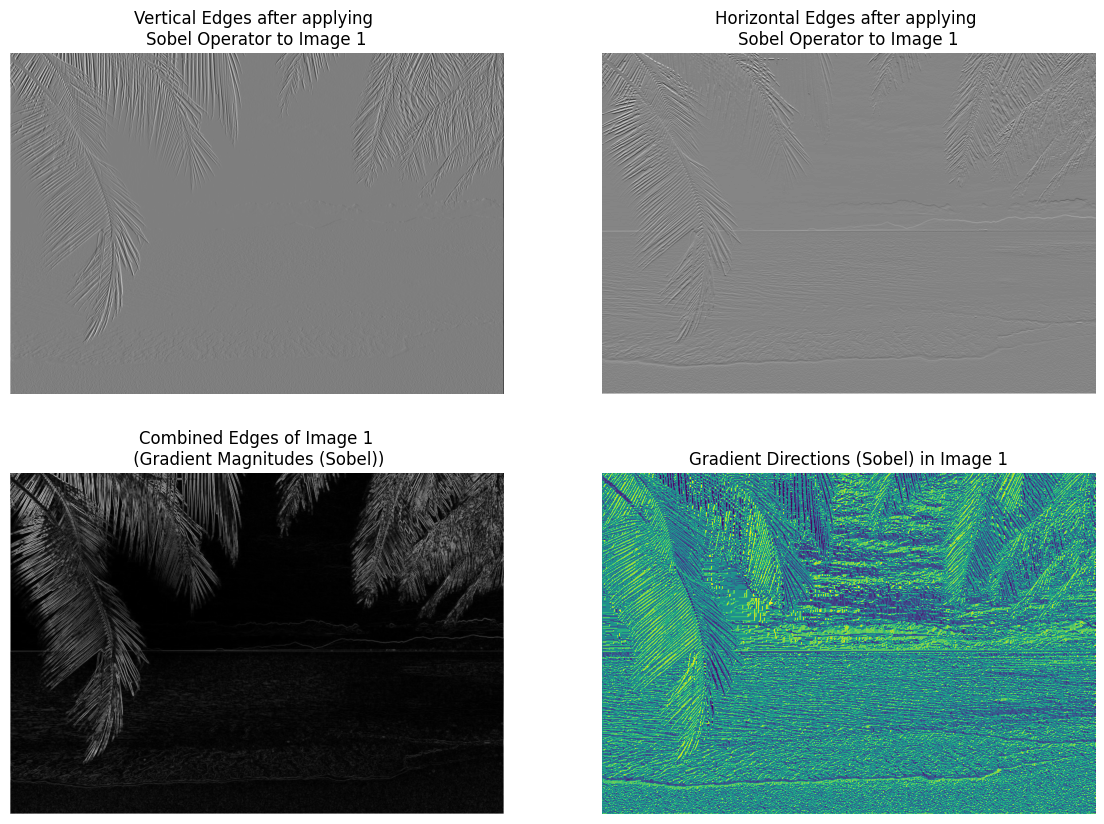

In [191]:
plot_results1(sobel_x1, sobel_y1, sobel_magnitudes1, sobel_directions1, (14, 10), 'Sobel', '1', save)

### Canny Edge Detector

**Step 1**: Apply Gaussian Blur to the image to reduce noise.

In [192]:
def gaussian_blur(sigma, k=2):
    """
    Generates a Gaussian Blur Filter with shape (2k + 1, 2k + 1), with
    the specified standard deviation.
    Args:
        sigma: The standard deviation of the Gaussian Blur
        k: The parameter that determines the shape of the filter (2 by default)
    Returns:
        G: The resulting Gaussian Blur Filter 
    """
    x, y = np.mgrid[-k: k + 1, -k: k + 1]
    G = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / 2 * np.pi * sigma ** 2
    return G

Plot a Gaussian Blur Filter of shape 11x11 and sigma 1 for illustration purposes

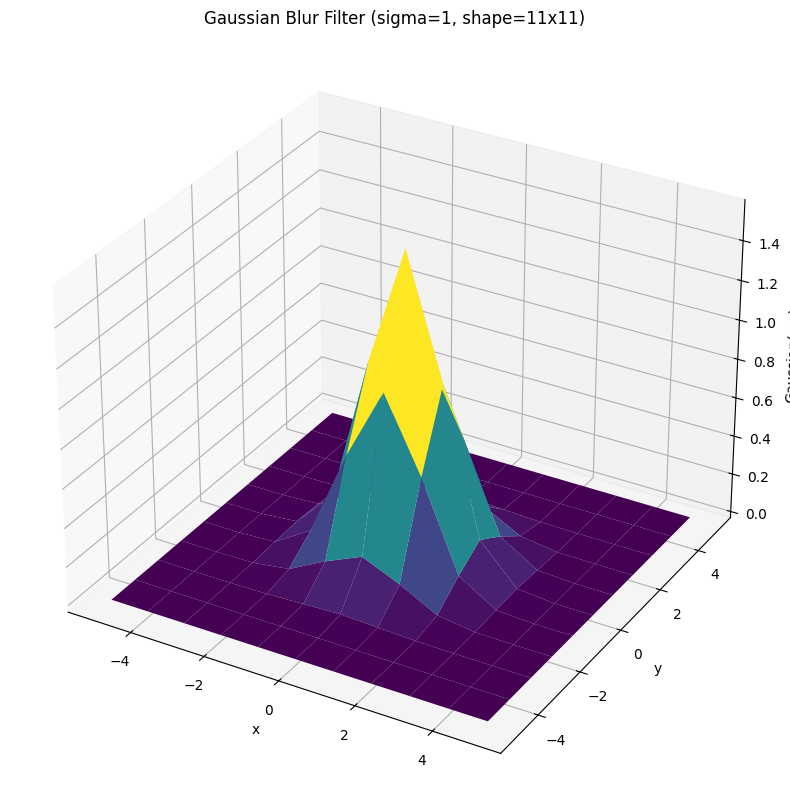

In [193]:
from mpl_toolkits import mplot3d # for 3D plotting

k_plt = 5
fig_3D = plt.figure(figsize=(15, 10))
ax_3D = plt.axes(projection='3d')
x_plt, y_plt = np.mgrid[-k_plt: k_plt + 1, -k_plt: k_plt + 1]
ax_3D.plot_surface(x_plt, y_plt, gaussian_blur(sigma=1, k=k_plt), rstride=1, cstride=1, 
                   cmap='viridis', edgecolor='none')
ax_3D.set_xlabel('x')
ax_3D.set_ylabel('y')
ax_3D.set_zlabel('Gaussian(x,y)')
plt.title('Gaussian Blur Filter (sigma=1, shape=11x11)')
#plt.savefig('gaussian_blur_3d.png')
plt.show()

**Step 2**: Gradient Calculation, use the **sobel** function implemented above for computing the graident magnitudes and directions. 

**Step 3**: Implement the Non-Maximum Suppression algorithm to thin out the detected edges.

In [194]:
def non_max_suppression(gradient_magnitudes, gradient_directions):
    """
    Implements the Non-Maximum Suppression algorithm to thin out the
    edges described as gradient magnitudes.
    Args:
        gradient_magnitudes: Edge intensities
        gradient_directions: Edge directions (angles in Radians)
    output:
        result: The processed edge intensities 
    """
    #INSERT YOUR CODE HERE
    height, width = gradient_magnitudes.shape
    output = np.zeros_like(gradient_magnitudes, dtype=np.uint8)

    quantized_directions = (np.round(gradient_directions / (np.pi/4)) % 4).astype(np.int32)
    
    for i in range(1, height-1):
        for j in range(1, width-1):
            mag = gradient_magnitudes[i, j]
            direction = quantized_directions[i, j]

            if direction == 0:
                prev_pixel = gradient_magnitudes[i, j-1]
                next_pixel = gradient_magnitudes[i, j+1]
            elif direction == 1:
                prev_pixel = gradient_magnitudes[i-1, j-1]
                next_pixel = gradient_magnitudes[i+1, j+1]
            elif direction == 2:
                prev_pixel = gradient_magnitudes[i-1, j]
                next_pixel = gradient_magnitudes[i+1, j]
            elif direction == 3:
                prev_pixel = gradient_magnitudes[i-1, j+1]
                next_pixel = gradient_magnitudes[i+1, j-1]

            if mag >= prev_pixel and mag >= next_pixel:
                output[i, j] = mag
    
    return output

**Step 4**: Implement the Double Thresholding algorithm to categorize pixels.

In [195]:
def double_threshold(img, ratio_low, ratio_high):
    """
    Categorizes the image pixels as strong, weak or non-edge
    using double thresholding, returns the thresholded image.
    Args:
        img: The input image
        ratio_low: The low threshold ratio 
        ratio_high: The high threshold ratio 
    Returns:
        thresholded_img: The thresholded output. Each pixel would take the value of 0, strong or weak intensities as set below. 
        weak: The intensity level of weak pixels
        strong: The intensity level of strong pixels
    """
    high = ratio_high * np.max(img)
    low = ratio_low * np.max(img)
    weak = 25
    strong = 255
    
    #INSERT YOUR CODE HERE

    thresholded_img = np.zeros_like(img)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] >= high:
                thresholded_img[i, j] = strong
            elif img[i, j] >= low:
                thresholded_img[i, j] = weak

    return thresholded_img, weak, strong

**Step 5**: Implement Hysteresis to combine the Strong and Weak pixels and produces the final result. 

In [196]:
def hysteresis(img, weak, strong):
    """
    Args:
        img: The input image
        weak: The weak intensity level
        strong: The strong intensity level
    Returns:
        output: The processed output image
    """
    #INSERT YOUR CODE HERE
    output = np.zeros_like(img)
    rows, cols = img.shape
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if img[i, j] == weak:
                if (img[i-1:i+2, j-1:j+2] == strong).any():
                    output[i, j] = strong
                else:
                    output[i, j] = 0
            elif img[i, j] == strong:
                output[i, j] = strong
    
    return output

Combine the five steps in a single algorithm:

In [197]:
def canny_edge_detector(img, sigma, ratio_low, ratio_high, k=2):
    """
    Applys Canny Edge Detection algorithm to a given image.
    Args:
        img: The input image
        sigma: The standard deviation of the 5x5 Gaussian Filter
           
        ratio_low: The low threshold ratio used in the Double Thresholding step
            
        ratio_high: The high threshold ratio used in the Double Thresholding step
            
        k: Parameter to adjust the shape of the (2k + 1, 2k + 1) gaussian blur 
    """
    G = gaussian_blur(sigma, k)
    blurred_img = cross_correlate2D(img, G)
    _, _, gradient_magnitudes, gradient_directions = sobel(blurred_img)
    nms_img = non_max_suppression(gradient_magnitudes, gradient_directions)
    thresholded_img, weak, strong = double_threshold(nms_img, ratio_low, ratio_high)
    output = hysteresis(thresholded_img, weak, strong)
    return output

Add your results and answers to the questions 5.2.1, 5.2.2 and 5.2.3 here

In [198]:
def show_canny_img(img, num): 
    plt.figure(figsize=(8, 8))
    plt.title(f'Canny Image {num} (Original)')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if save:
        plt.savefig(f'canny{num}.png')
    plt.show()

Canny Edge Detection for edge1.png

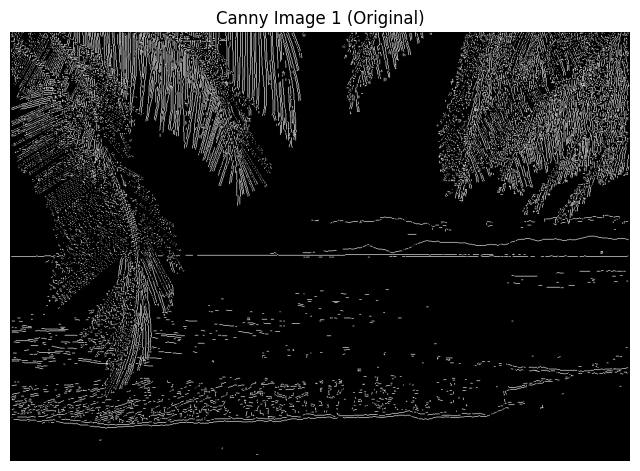

In [199]:
img1 = rgb2gray(mpimg.imread('edge1.png'))
canny_img1 = canny_edge_detector(img1, 1, 0.05, 0.1)
show_canny_img(canny_img1, 1)

Canny Edge Detection for edge2.png

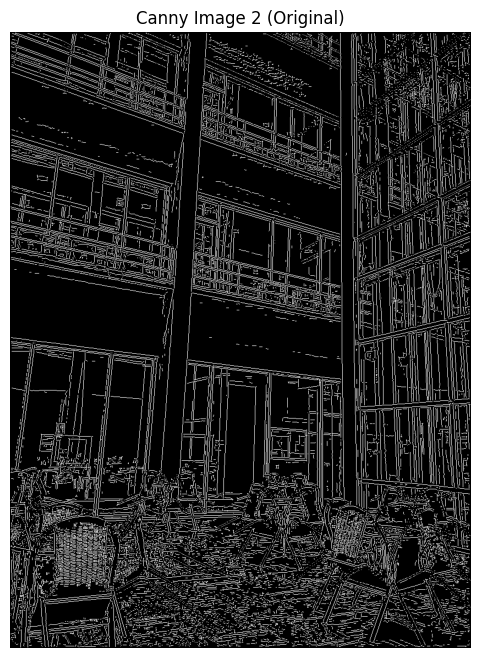

In [206]:
import cv2 #used for importing edge2.png

img2 = rgb2gray(cv2.imread('edge2.png'))
canny_img2 = canny_edge_detector(img2, 1, 0.01, 0.025)
show_canny_img(canny_img2, 2)

Canny Edge Detection for edge3.png

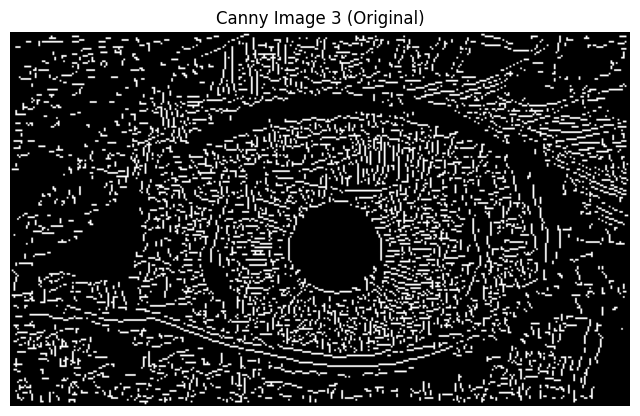

In [201]:
img3 = rgb2gray(mpimg.imread('edge3.png'))
canny_img3 = canny_edge_detector(img3, 1, 0.05, 0.1)
show_canny_img(canny_img3, 3)

5.2.1
After some trial and error I decided on the following parameter values for the Canny Edge Detection: 
|img|sigma|t_low|t_high|
| --- | --- | --- | --- |
|edge1.png|1|0.05|0.1|
|edge2.png|1|0.01|0.025|
|edge3.png|1|0|0|
